# CAICT 風機結冰預測 - Baseline

2017/07/23  
http://www.industrial-bigdata.com/competition/competitionAction!showDetail.action?competition.competitionId=1

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


### Summary

### Outline
- [1. Load Data and Modules](#load)  
- [2. Select Features](feature)
- [3. Check Auto Correlation](#autocorrelation)
- [4. Modeling](#modeling)



<a id='load'></a>
## 1. Load Data and Modules

In [2]:
import pandas as pd
import os
import sys
from PIL import Image
import numpy as np
import lzma
import pickle
from IPython.display import display
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
import shutil
import matplotlib.pyplot as plt
import shutil
import csv
import sklearn as sk
from sklearn.metrics import roc_curve, auc 
from sklearn.metrics import precision_score
import matplotlib.gridspec as gridspec
import seaborn as sns
from pylab import *
from collections import OrderedDict

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn import tree
from sklearn import cross_validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import RFE
from sklearn import svm
import xgboost as xgb
from mlxtend.classifier import StackingClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from IPython.core.interactiveshell import InteractiveShell
%matplotlib inline
pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "all"

/Users/jayhsu/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
def variable_summaries(var, name):  
    with tf.name_scope('summaries_'+str(name)):  
        mean = tf.reduce_mean(var)  
        tf.summary.scalar('mean', mean)  
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))  
        tf.summary.scalar('stddev', stddev)  
        tf.summary.scalar('max', tf.reduce_max(var))  
        tf.summary.scalar('min', tf.reduce_min(var))  
        tf.summary.histogram('histogram', var)  
        
def updateProgress(msg):
    sys.stdout.write('\r')
    sys.stdout.write(msg)
    sys.stdout.flush()

def normalize(data):
    standard_scaler = preprocessing.StandardScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    return data_scaled


In [4]:

def load_resample_data(id, policy=1):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=id,POLICY=policy)
    data_resample = pd.read_csv(filename)
    #data_resample['label']=data_resample['label'].fillna(2)
    data_resample = data_resample[data_resample['label']!=2]
    data_resample=data_resample.dropna()
    data_X = data_resample.drop(['label','time','group','timestamp','event'], axis=1)
    data_y = data_resample['label']
    data_Y = np.eye(data_y.unique().size)[data_y.values.astype(int)]
    return data_resample, data_X, data_Y, data_y

def load_resample_data_split(id, split_case, policy=1):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=id,POLICY=policy)
    data_resample = pd.read_csv(filename)
    #data_resample['label']=data_resample['label'].fillna(2)
    data_resample = data_resample[data_resample['label']!=2]
    data_resample=data_resample.dropna()
    data_resample_train = data_resample[data_resample['event']<split_case]
    data_resample_valid = data_resample[data_resample['event']>=split_case]
    train_X = data_resample_train.drop(['label','time','group','timestamp','event'], axis=1)
    train_y = data_resample_train['label']
    valid_X = data_resample_valid.drop(['label','time','group','timestamp','event'], axis=1)
    valid_y = data_resample_valid['label']
    train_Y = np.eye(train_y.unique().size)[train_y.values.astype(int)]
    valid_Y = np.eye(valid_y.unique().size)[valid_y.values.astype(int)]
    return data_resample, train_X, train_Y, train_y, valid_X, valid_Y, valid_y


def load_test2_data(varsel=False):
    test_data = pd.read_csv('data/ice1/test/08/08_data.csv')
    if varsel:
        test_data=variable_selection(test_data,isTest=True)
    test_timeidx = test_data['time']
    tmp = test_data.drop(['time','group'], axis=1)
    test_X = tmp
    return test_data, test_X, test_timeidx


In [5]:
def myscore(true_y, pred_y):
    n,p =sk.metrics.confusion_matrix(true_y, pred_y)
    tn = n[0]
    fp = n[1]
    fn = p[0]
    tp = p[1]
    score = 1- 0.5*(fp/(tn+fp))- 0.5*(fn/(fn+tp)) 
    prec= precision_score(true_y, pred_y)
    recall = recall_score(true_y, pred_y)
    accuracy = accuracy_score(true_y,pred_y)
    confusions = (
    ('tn', tn),
    ('fn', fn),
    ('tp', tp),
    ('fp', fp)
    )
    msg = 'Score:{sco:.2f} \n\taccuracy:{acc:.2f}, \n\trecall:{rcl:.2f}, \n\tprecision:{psc:.2f}\n\t{cfmt}'.format(sco=score,acc=accuracy,rcl=recall,psc=prec,cfmt=confusions)
    return score, accuracy, prec, recall, OrderedDict(confusions),msg

def mycv(model_log, train_X, train_y):
    skf = cross_validation.StratifiedKFold(train_y.values,10)
    score_list=[]
    accuracy_list=[]
    precision_list = []
    recall_list=[]
    for train,test in skf:
        model_log = model_log.fit(train_X.values[train],train_y.values[train])
        pred_y = model_log.predict(train_X.values[test])       
        score, accuracy, precision, recall, cmt, msg = myscore(train_y.values[test], pred_y)
        score_list.append(score)
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
    msg = 'Score:{sco:.2f} \n\taccuracy:{acc:.2f}, \n\trecall:{rcl:.2f}, \n\tprecision:{psc:.2f}'.format(sco=np.mean(score_list),acc=np.mean(accuracy_list),rcl=np.mean(recall_list),psc=np.mean(precision_list))
    return np.mean(score_list), msg

***

**Load input data.** 

In [6]:
#train_raw, train_X, train_Y, train_y, valid_X, valid_Y, valid_y =load_resample_data_split(id=15, policy=3, split_case = 20 )
train_raw, train_X, train_Y, train_y = load_resample_data(id=15, policy=3)
train_21_raw, train_21_X, train_21_Y, train_21_y = load_resample_data(id=21, policy=3)
valid_raw, valid_21_X, valid_21_Y, valid_21_y = load_resample_data(id=21, policy=0)
test_raw, test_X,test_timeidx = load_test2_data(varsel=False)

** Normalize **

In [7]:
train_X = normalize(train_X)
train_21_X = normalize(train_21_X)
valid_21_X = normalize(valid_21_X)
test_X = normalize(test_X)

**風機15 Training/Validation Data 狀態正常(0)/異常(1)比例 **

In [8]:
train_raw['time']=pd.to_datetime(train_raw['time'])
train_raw['label'].value_counts()
data_failure = train_raw[train_raw['label']==1]
data_normal = train_raw[train_raw['label']==0]
msg = '正常:{i} ({j:.2f} percent), 結冰:{k:} ({m:.2f} percent), Total:{n}'.format(i=len(data_normal), j=len(data_normal)/len(train_raw),k=len(data_failure),m=len(data_failure)/len(train_raw), n=len(train_raw))   
print(msg,'\n')
#print(data.info())

1.0    25952
0.0    21602
Name: label, dtype: int64

正常:21602 (0.45 percent), 結冰:25952 (0.55 percent), Total:47554 



<a id='feature'></a>
## 2. Select Features

** Test and select the model features **

In [15]:
print('Feature Ranking:')
rfe = RFE(LogisticRegression(), 1)
fit = rfe.fit(train_X,train_y)
feature_imp = pd.DataFrame(list(zip(train_X.columns, np.transpose(fit.ranking_))), columns=['feature','ranking'])
feature_imp = feature_imp.sort_values(by='ranking', ascending=True).reset_index(drop=True)
feature_imp

Feature Ranking:


,feature,ranking
0,power,1
1,wind_speed,2
2,environment_tmp,3
3,int_tmp,4
4,pitch1_moto_tmp,5
5,pitch1_angle,6
6,t-100,7
7,t-1,8
8,t-2,9
9,wind_direction_mean,10


**Summary:**   
目前，特徵選擇最流行方法是遞歸特徵選擇（Recursive Feature Selection，RFE）。  
RFE 可以創建預測模型，對特徵值賦予不同的權值，並刪掉那些權重最小的特徵，通過不斷重複這一流程，最終就能得到預期數量的特徵

透過REF排序的Variable, 和Data Exploration得到的結論大致相同, 綜合評估後, 留下以下Variable
 - 'power', 'pitch1_angle', 'pitch1_speed','pitch1_moto_tmp', 'wind_speed', 'wind_direction_mean', 'environment_tmp', 'int_tmp'

** Variable Selection (according to the data exploration & RFE ranking)**

In [10]:
suspect_vars = ['power', 'pitch1_angle',  'pitch1_speed','pitch1_moto_tmp','wind_speed', 'wind_direction_mean', 'environment_tmp', 'int_tmp' ]
train_X = train_X[suspect_vars]
train_21_X = train_21_X[suspect_vars]
valid_21_X = valid_21_X[suspect_vars]
test_X = test_X[suspect_vars]

<a id='autocorrelation'></a>
### 3. Check Auto Correlation

/Users/jayhsu/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


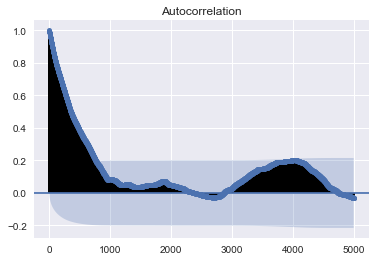

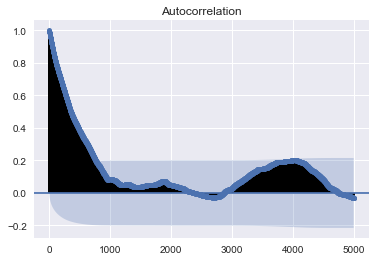

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

power_wer = train_X['power']
plot_acf(power_wer,lags=5000)
#plot_acf(label_ser, lags=50)
#plt.show()

In [12]:
for i in range(100,0,-1):
    train_X['t-'+str(i)] = train_X['power'].shift(i)
    
train_X = train_X[101:]
train_y = train_y[101:]

In [13]:
for i in range(100,0,-1):
    train_21_X['t-'+str(i)] = train_21_X['power'].shift(i)

train_21_X = train_21_X[101:]
train_21_y = train_21_y[101:]


In [14]:
for i in range(100,0,-1):
    valid_21_X['t-'+str(i)] = valid_21_X['power'].shift(i)

valid_21_X = valid_21_X[101:]
valid_21_y = valid_21_y[101:]

<a id='modeling'></a>
### 4. Modeling

** 1. Logistic Regression **

In [225]:
model_log = LogisticRegression()
score_log, msg = mycv(model_log, train_X,train_y)
print('train(15):',msg)

model_log = model_log.fit(train_X.values,train_y.values)
pred_y = model_log.predict(valid_21_X.values)
score_log_21, accuracy, precision, recall, cmt, msg=myscore(valid_21_y, pred_y)
print('\ntest(21):',msg)

train(15): Score:0.77 
	accuracy:0.78, 
	recall:0.81, 
	precision:0.81

test(21): Score:0.70 
	accuracy:0.47, 
	recall:0.97, 
	precision:0.10
	(('tn', 73696), ('fn', 332), ('tp', 10306), ('fp', 95133))


** 2. Perceptron**

In [226]:
model_prcp = Perceptron(
    class_weight='balanced'
    )
score_pctr, msg = mycv(model_prcp, train_X,train_y)
print('train(15):',msg)

model_prcp = model_prcp.fit(train_X.values,train_y.values)
pred_y = model_prcp.predict(valid_21_X.values)
score_pctr_21, accuracy, precision, recall, cmt, msg=myscore(valid_21_y, pred_y)
print('\ntest(21):',msg)

train(15): Score:0.75 
	accuracy:0.75, 
	recall:0.78, 
	precision:0.81

test(21): Score:0.76 
	accuracy:0.62, 
	recall:0.91, 
	precision:0.13
	(('tn', 101457), ('fn', 957), ('tp', 9681), ('fp', 67372))


** 3. K Nearest Neighbours **

In [169]:
model_knn = KNeighborsClassifier(
    n_neighbors=10,
    weights='distance'
    )
score_knn, msg = mycv(model_knn, train_X,train_y)
print('train(15):',msg)

model_knn = model_knn.fit(train_X.values,train_y.values)
pred_y = model_knn.predict(valid_21_X.values)
score_knn_21, accuracy, precision, recall, cmt, msg=myscore(valid_21_y, pred_y)
print('\ntest(21):',msg)

train(15): Score:0.68 
	accuracy:0.68, 
	recall:0.74, 
	precision:0.72

test(21): Score:0.75 
	accuracy:0.67, 
	recall:0.85, 
	precision:0.14
	(('tn', 111692), ('fn', 1627), ('tp', 9011), ('fp', 57238))


**4. Support Vector Machine**

In [170]:
model_svm = svm.SVC(
    class_weight='balanced'
    )
score_knn, msg = mycv(model_svm, train_X,train_y)
print('train(15):',msg)

model_svm = model_svm.fit(train_X.values,train_y.values)
pred_y = model_svm.predict(valid_21_X.values)
score_svm_21, accuracy, precision, recall, cmt, msg=myscore(valid_21_y, pred_y)
print('\ntest(21):',msg)

train(15): Score:0.70 
	accuracy:0.71, 
	recall:0.78, 
	precision:0.74

test(21): Score:0.77 
	accuracy:0.61, 
	recall:0.96, 
	precision:0.13
	(('tn', 98772), ('fn', 464), ('tp', 10174), ('fp', 70158))


**5. Decision Tree**

In [171]:
model_tree = tree.DecisionTreeClassifier(
    #max_depth=3,\
    class_weight="balanced",\
    min_weight_fraction_leaf=0.01\
    )
score_tree, msg = mycv(model_tree, train_X,train_y)
print('train(15):',msg)

model_tree = model_tree.fit(train_X.values,train_y.values)
pred_y = model_tree.predict(valid_21_X.values)
score_tree_21, accuracy, precision, recall, cmt, msg=myscore(valid_21_y, pred_y)
print('\ntest(21):',msg)

train(15): Score:0.68 
	accuracy:0.68, 
	recall:0.72, 
	precision:0.73

test(21): Score:0.61 
	accuracy:0.58, 
	recall:0.64, 
	precision:0.09
	(('tn', 97761), ('fn', 3833), ('tp', 6805), ('fp', 71169))


***

**集成算法**的目标是：组合几个基学习器的预测，以此来提高单个模型的泛化性和健壮性
集成方法常分为两类：
- averging methods：平均法的原则是： 独立的构建几个学习器，然后平均他们的预测。通常，组合的学习器要比任何一个单个的学习器要好，因为它降低了方差。   其中的代表：bagging 方法，随即森林
- boosting methods：学习器依次构建，试图降低组合的学习器的偏差。                                                                                                                                           其中的代表：AdaBoost，Gradient Tree Boosting

**6. Bagging**

In [172]:
model_bag = BaggingClassifier(
    KNeighborsClassifier(
        n_neighbors=2,
        weights='distance'
        ),
    oob_score=True,
    max_samples=0.5,
    max_features=1.0
    )
score_bag, msg = mycv(model_bag, train_X,train_y)
print('train(15):',msg)

model_bag = model_bag.fit(train_X.values,train_y.values)
pred_y = model_bag.predict(valid_21_X.values)
score_bag_21, accuracy, precision, recall, cmt, msg=myscore(valid_21_y, pred_y)
print('\ntest(21):',msg)

train(15): Score:0.67 
	accuracy:0.68, 
	recall:0.74, 
	precision:0.71

test(21): Score:0.75 
	accuracy:0.68, 
	recall:0.84, 
	precision:0.14
	(('tn', 112295), ('fn', 1714), ('tp', 8924), ('fp', 56635))


**7. Random Forest**

In [173]:
model_rf = RandomForestClassifier(
    n_estimators=1000, \
    max_depth=None, \
    min_samples_split=10 \
    #class_weight="balanced", \
    #min_weight_fraction_leaf=0.02 \
    )
score_rf, msg = mycv(model_rf, train_X,train_y)
print('train(15):',msg)

model_rf = model_rf.fit(train_X.values,train_y.values)
pred_y = model_rf.predict(valid_21_X.values)
score_rf_21, accuracy, precision, recall, cmt, msg=myscore(valid_21_y, pred_y)
print('\ntest(21):',msg)

train(15): Score:0.69 
	accuracy:0.70, 
	recall:0.71, 
	precision:0.75

test(21): Score:0.72 
	accuracy:0.64, 
	recall:0.80, 
	precision:0.12
	(('tn', 107175), ('fn', 2123), ('tp', 8515), ('fp', 61755))


**8. Extremely Randomised Trees**

In [174]:
model_etrtree = ExtraTreesClassifier(
    max_features='auto',
    bootstrap=True,
    oob_score=True,
    n_estimators=1000,
    max_depth=None,
    min_samples_split=10
    #class_weight="balanced",
    #min_weight_fraction_leaf=0.02
    )
score_ext, msg = mycv(model_etrtree, train_X,train_y)
print('train(15):',msg)

model_etrtree = model_etrtree.fit(train_X.values,train_y.values)
pred_y = model_etrtree.predict(valid_21_X.values)
score_ext_21, accuracy, precision, recall, cmt, msg=myscore(valid_21_y, pred_y)
print('\ntest(21):',msg)

train(15): Score:0.69 
	accuracy:0.70, 
	recall:0.79, 
	precision:0.73

test(21): Score:0.76 
	accuracy:0.64, 
	recall:0.90, 
	precision:0.13
	(('tn', 105102), ('fn', 1062), ('tp', 9576), ('fp', 63828))


**9. Gradient Boosting:**

In [177]:
model_gb = GradientBoostingClassifier(
            #loss='exponential',
            n_estimators=1000,
            learning_rate=0.1,
            max_depth=3,
            subsample=0.5,
            random_state=0)

score_gb, msg = mycv(model_gb, train_X,train_y)
print('train(15):',msg)

model_gb = model_gb.fit(train_X.values,train_y.values)
pred_y = model_gb.predict(valid_21_X.values)
score_gb_21, accuracy, precision, recall, cmt, msg=myscore(valid_21_y, pred_y)
print('\ntest(21):',msg)

train(15): Score:0.70 
	accuracy:0.70, 
	recall:0.70, 
	precision:0.74

test(21): Score:0.59 
	accuracy:0.49, 
	recall:0.70, 
	precision:0.08
	(('tn', 80163), ('fn', 3205), ('tp', 7433), ('fp', 88767))


**9. Ada Boost:**

In [179]:
model_ada = AdaBoostClassifier(n_estimators=400, learning_rate=0.1)

score_ada, msg = mycv(model_ada, train_X,train_y)
print('train(15):',msg)

model_ada = model_ada.fit(train_X.values,train_y.values)
pred_y = model_ada.predict(valid_21_X.values)
score_ada_21, accuracy, precision, recall, cmt, msg=myscore(valid_21_y, pred_y)
print('\ntest(21):',msg)

train(15): Score:0.71 
	accuracy:0.72, 
	recall:0.78, 
	precision:0.74

test(21): Score:0.57 
	accuracy:0.50, 
	recall:0.65, 
	precision:0.07
	(('tn', 82298), ('fn', 3677), ('tp', 6961), ('fp', 86632))


**10. eXtreme Gradient Boosting:**

In [178]:
model_xgb = xgb.XGBClassifier(
    max_depth=2,
    n_estimators=500,
    subsample=0.5,
    learning_rate=0.1
    )

score_xgb, msg = mycv(model_xgb, train_X,train_y)
print('train(15):',msg)

model_xgb = model_xgb.fit(train_X.values,train_y.values)
pred_y = model_xgb.predict(valid_21_X.values)
score_xgb_21, accuracy, precision, recall, cmt, msg=myscore(valid_21_y, pred_y)
print('\ntest(21):',msg)

train(15): Score:0.74 
	accuracy:0.74, 
	recall:0.72, 
	precision:0.81

test(21): Score:0.61 
	accuracy:0.55, 
	recall:0.67, 
	precision:0.08
	(('tn', 91531), ('fn', 3466), ('tp', 7172), ('fp', 77399))


***

### Ranking of models and features

In [180]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Gradient Boosting', 'Bagging', 
              'Decision Tree','XGBoost','ExtraTree','Perceptron','Ada Boost'],
    'Score': [score_svm, score_knn, score_log, score_rf, score_gb, score_bag,
              score_tree,score_xgb,score_ext,score_pctr,score_ada]})
models.sort_values(by='Score', ascending=False)

,Model,Score
2,Logistic Regression,0.775044
7,XGBoost,0.737911
10,Ada Boost,0.711719
1,KNN,0.702381
4,Gradient Boosting,0.700501
3,Random Forest,0.693692
8,ExtraTree,0.690164
6,Decision Tree,0.678711
5,Bagging,0.673990
9,Perceptron,0.662340


In [181]:
models_21 = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Gradient Boosting', 'Bagging', 
              'Decision Tree','XGBoost','ExtraTree','Perceptron','Ada Boost'],
    'Score': [score_svm_21, score_knn_21, score_log_21, score_rf_21, score_gb_21, score_bag_21,
              score_tree_21,score_xgb_21,score_ext_21,score_pctr_21,score_ada_21]})
models_21.sort_values(by='Score', ascending=False)

,Model,Score
0,Support Vector Machines,0.770537
8,ExtraTree,0.761166
1,KNN,0.754115
5,Bagging,0.751811
3,Random Forest,0.717433
2,Logistic Regression,0.701684
9,Perceptron,0.660833
6,Decision Tree,0.609198
7,XGBoost,0.608007
4,Gradient Boosting,0.586628


In [182]:
summary = pd.DataFrame(list(zip(train_X.columns, \
    np.transpose(model_log.coef_), \
    np.transpose(model_prcp.coef_), \
#    np.transpose(model_knn.feature_importances_), \
    np.transpose(model_tree.feature_importances_), \
    np.transpose(model_rf.feature_importances_), \
    np.transpose(model_etrtree.feature_importances_), \
    np.transpose(model_gb.feature_importances_), \
    np.transpose(model_ada.feature_importances_), \
    np.transpose(model_xgb.feature_importances_), \
#    np.transpose(model_svm.coef_), \
#    np.transpose(model_bag.feature_importances_), \
    )), columns=['Feature','LogisticRegression','Perceptron','Tree','RF','Extra','GB','Ada','Xtreme'])
  
summary['Median'] = summary.median(1)
summary.sort_values('Median', ascending=False)

,Feature,LogisticRegression,Perceptron,Tree,RF,Extra,GB,Ada,Xtreme,Median
6,environment_tmp,[-2.0195154126],[-3.65644984304],0.294716,0.210125,0.203827,0.282324,0.2775,0.234043,0.255771
0,power,[-4.03357290242],[-5.71725870191],0.324522,0.227583,0.233905,0.155770,0.1925,0.164722,0.210041
3,pitch1_moto_tmp,[0.495303750806],[-0.0365880278932],0.244623,0.167403,0.159331,0.151803,0.1500,0.213452,0.163367
7,int_tmp,[1.14143171134],[3.4171550838],0.073691,0.166964,0.159363,0.161767,0.1800,0.155800,0.160565
1,pitch1_angle,[-0.453465406131],[-0.790419825515],0.023959,0.120146,0.147309,0.106088,0.0925,0.159231,0.113117
4,wind_speed,[2.91056944815],[7.76986546901],0.038490,0.099502,0.086652,0.089559,0.1075,0.062457,0.088106
5,wind_direction_mean,[-0.281358988827],[-1.93864251716],0.000000,0.007202,0.008733,0.037199,0.0000,0.010295,0.007968
2,pitch1_speed,[0.0271154898947],[-2.93053483962],0.000000,0.001075,0.000880,0.015490,0.0000,0.000000,0.000440


***
### Optimising one classifier in more detail:

clf_xgb = xgb.XGBClassifier(subsample=0.5)
param_grid = {'max_depth':[2,3,5,7,9],
              'learning_rate':[0.1,0.01],
              #'booster': ['gbtree', 'gblinear', 'dart'],
              'n_estimators': [100, 500,1000]
              }
gs = GridSearchCV(estimator=clf_xgb, param_grid=param_grid, scoring='accuracy', cv=3)
gs = gs.fit(train_X,train_y)
print(gs.best_score_)
print(gs.best_params_)

clf_xgb = xgb.XGBClassifier(subsample=0.5)
param_grid = {'max_depth':[2,3,5,7,9],
              'learning_rate':[0.1,0.01],
              'n_estimators': [100, 500,1000]
              }
gs = GridSearchCV(estimator=clf_xgb, param_grid=param_grid, scoring='recall', cv=3)
gs = gs.fit(train_X,train_y)
print(gs.best_score_)
print(gs.best_params_)

clf_xgb = xgb.XGBClassifier(subsample=0.5)
param_grid = {'max_depth':[2,3,5,7,9],
              'learning_rate':[0.1,0.01],
              'n_estimators': [100, 500,1000]
              }
gs = GridSearchCV(estimator=clf_xgb, param_grid=param_grid, scoring='precision', cv=3)
gs = gs.fit(train_X,train_y)
print(gs.best_score_)
print(gs.best_params_)

model_xgb = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.01,
    n_estimators=1000
    )
model_xgb = model_xgb.fit(train_X,train_y)
pred_y = model_xgb.predict(valid_X)
score_xgb, accuracy, precision, recall, cmt, msg=myscore(valid_y, pred_y)
print(msg)

pd.DataFrame(list(zip(valid_X.columns, np.transpose(model_xgb.feature_importances_))) \
            ).sort_values(1, ascending=False)



scores = cross_val_score(clf_xgb, train_X,train_y, cv=5)
print(scores)
print("Mean score(train) = %.3f, Std deviation = %.3f"%(np.mean(scores),np.std(scores)))

score_ext_test= cross_val_score(clf_xgb, valid_X,valid_y, cv=5)
print(score_ext_test)
print("Mean score(validation) = %.3f, Std deviation = %.3f"%(np.mean(score_ext_test),np.std(score_ext_test)))

### Stacking / Ensemble methods

In [244]:
train_X_new = np.concatenate((train_X, train_21_X), axis=0)
train_y_new = np.concatenate((train_y, train_21_y), axis=0)
#model_log = model_log.fit(train_X_new, train_y_new)
#model_ada = model_ada.fit(train_X_new, train_y_new)

#model_bag = model_bag.fit(train_X_new, train_y_new)
#model_xgb = model_xgb.fit(train_X_new, train_y_new)
#model_prcp = model_prcp.fit(train_X_new, train_y_new)
#model_svm = model_svm.fit(train_X_new, train_y_new)
#model_etrtree = model_etrtree.fit(train_X_new, train_y_new)
#model_gb = model_gb.fit(train_X_new, train_y_new)
#model_rf = model_rf.fit(train_X_new, train_y_new)

** VotingClassifier **

In [185]:
clf_vote = VotingClassifier(
    estimators=[
        ('svm', model_svm),
        ('extra', model_etrtree),
        ('knn', model_knn),
        ('bag', model_bag),
        ('RF', model_rf),
        ('logistic', model_log),
       # ('ada', model_ada),
       # ('xgb', model_xgb),
       # ('percep', model_prcp),
       # ('gb', model_gb),
        #('tree', model_tree)
        ],
    weights=[1,1,1,1,1,1],
    voting='hard')

score_vte, msg = mycv(clf_vote, train_X,train_y)
print('train(15):',msg)

clf_vote = clf_vote.fit(train_X.values,train_y.values)
pred_y = clf_vote.predict(valid_21_X.values)
score_vte_21, accuracy, precision, recall, cmt, msg=myscore(valid_21_y, pred_y)
print('\ntest(21):',msg)

KeyboardInterrupt: 

In [36]:
clf_vote = VotingClassifier(
    estimators=[
        ('logistic', model_log),
        ('ada', model_ada),
        ('bag', model_bag),
        ('xgb', model_xgb),
        ('percep', model_prcp),
        #('knn', model_knn),
        ('svm', model_svm),
        ('extra', model_etrtree),
        ('gb', model_gb),
        ('RF', model_rf)
        #('tree', model_tree)
        ],
    weights=[1,1,1,1,1,1,1,1,1],
    voting='hard')

clf_vote = clf_vote.fit(train_X,train_y)
pred_y = clf_vote.predict(valid_21_X)
score_xgb, accuracy, precision, recall, cmt, msg=myscore(valid_y, pred_y)
print(msg)

Score:0.5086665914754662 
	accuracy:0.5088064889918887, 
	recall:0.38793503480278424, 
	precision:0.5108463183623587
	(('tn', 2719), ('fn', 2638), ('tp', 1672), ('fp', 1601))


In [37]:
pred_y = clf_vote.predict(valid_21_X)
score_xgb, accuracy, precision, recall, cmt, msg=myscore(valid_21_y, pred_y)
print(msg)

Score:0.7668573112162218 
	accuracy:0.5926612759511717, 
	recall:0.9644670050761421, 
	precision:0.12357425897599576
	(('tn', 96163), ('fn', 378), ('tp', 10260), ('fp', 72767))


***

In [ ]:
clf_vote = clf_vote.fit(train_X_new,train_y_new)

** Predict Test Data**

In [ ]:
pred_T = clf_vote.predict(test_X.values)
pred_T_df = pd.DataFrame(pred_T)


In [ ]:
pred_T_result = pred_T_df[0]
pred_T_result.value_counts()

In [ ]:
startTime=0
endTIme=0
search_start=True
search_end=False
abnormal_list=[]
test_timeidx=test_timeidx.astype(int)
for i,v in enumerate(pred_T_result):
    if (v==1) & (search_start):
        startTime = test_timeidx[i]
        search_end=True
        search_start=False
    if (v==0) & (search_end):
        endTIme=test_timeidx[i]
        search_start=True
        search_end=False
        abnormal_list.append((startTime,test_timeidx[i-1]))
len(abnormal_list)
abnormal_list[:10]

In [ ]:
output_ans=True
if(output_ans):
    with open('test1_08_results.csv','w') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['startTime','endTime'])
        for row in abnormal_list:
            dummy = csv_out.writerow(row)

print('done')